In [ ]:
#!pip install keras-tuner
#!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import keras_tuner as kt
from sklearn.preprocessing import OneHotEncoder
import string
import random
from keras.utils import plot_model
from warnings import filters
import os
import zipfile
import pathlib

2024-10-12 06:36:55.501767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 06:36:55.639863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 06:36:55.680269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 06:36:55.940582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-12 06:36:57.952258: W tensorflow/compiler/tf2

## Dynamic Paths ##

In [7]:
curr_dir_path = pathlib.Path.cwd()
curr_dir_parent = curr_dir_path.parent


In [22]:
def model_checkpoint(model_name,directory=str(curr_dir_path)+"/Skimlit_model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(
      filepath=os.path.join(directory,model_name),
      save_best_only=True,
      save_weights_only=True,
      monitor="val_accuracy",
      verbose=0
  )

## Import All required dataset from github

In [8]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 1.06 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [9]:
with open(str(curr_dir_path)+"/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt",'r') as f:
  data = f.readlines()
data

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Preprocessing our text dataset and prepare it for our models

### Creating A function that will extract the lines from our text file and convert into a pandas dataframe ###
  About **get_lines()** :- This function will extract the lines, total number of lines in a paragraph and each line number from the text file.
  

In [10]:
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()



def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number+1 # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else:
      abstract_lines += line

  return abstract_samples

In [11]:
train_samples = preprocess_text_with_line_numbers(str(curr_dir_path)+"/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
test_samples = preprocess_text_with_line_numbers(str(curr_dir_path)+"/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")
val_samples = preprocess_text_with_line_numbers(str(curr_dir_path)+"/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt")

In [12]:
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
val_df = pd.DataFrame(val_samples)

### Converting the string values (target labels) into numerical ones using one hot encoding

In [13]:
#Preprocessing train dataframe
ohc = OneHotEncoder(sparse_output=False,handle_unknown="ignore")
ohc_df = ohc.fit_transform(train_df[["target"]])
ohc_train_df = train_df.copy()
ohc_train_df[ohc.get_feature_names_out()]=ohc_df
ohc_train_df =ohc_train_df.drop("target",axis=1)
ohc_train_df.head()

,text,line_number,total_lines,target_BACKGROUND,target_CONCLUSIONS,target_METHODS,target_OBJECTIVE,target_RESULTS
0,to investigate the efficacy of @ weeks of dail...,1,12,0.0,0.0,0.0,1.0,0.0
1,a total of @ patients with primary knee oa wer...,2,12,0.0,0.0,1.0,0.0,0.0
2,outcome measures included pain reduction and i...,3,12,0.0,0.0,1.0,0.0,0.0
3,pain was assessed using the visual analog pain...,4,12,0.0,0.0,1.0,0.0,0.0
4,secondary outcome measures included the wester...,5,12,0.0,0.0,1.0,0.0,0.0


In [14]:
#Prerpocessing Test dataframe
ohc_test_df = test_df.copy()
data=ohc.transform(test_df[["target"]])
ohc_test_df[ohc.get_feature_names_out()]=data
ohc_test_df =ohc_test_df.drop("target",axis=1)
#Preprocessing Validation dataframe
ohc_val_df = val_df.copy()
data=ohc.transform(val_df[["target"]])
ohc_val_df[ohc.get_feature_names_out()]=data
ohc_val_df =ohc_val_df.drop("target",axis=1)

## Creating A textVectorizer for our first model ##
**Explanation Of Every Steps**:-
  1) As we are creating a text vectorizer(word_level) which convert out words into numbers but our sentences are of different lengths so we need to find out a average length which would cover most of the portion our length

In [15]:
#Extracting sentences from train dataframe(one hot encoded)
train_sentence = ohc_train_df["text"].to_list()
train_sentence

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [16]:
avg_sentence_length = np.mean([len(sentence.split(" ")) for sentence in train_sentence])
avg_sentence_length

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

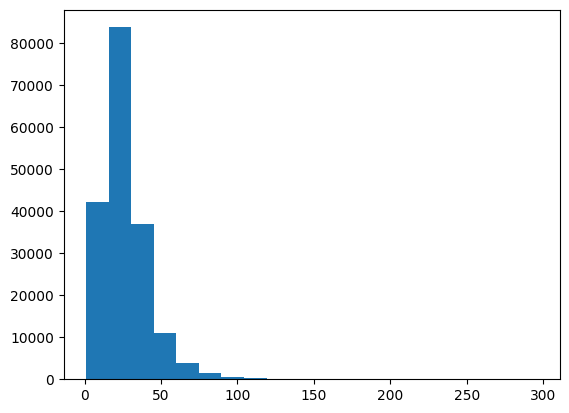

In [17]:
plt.hist([len(sentence.split(" ")) for sentence in train_sentence],bins=20)

In [18]:
#It means 95 percent of sentences are of 55 length
np.percentile([len(sentence.split(" ")) for sentence in train_sentence],95)

55.0

In [19]:
text_vect = layers.TextVectorization(
    max_tokens=68000,
    output_sequence_length=int(np.percentile([len(sentence.split(" ")) for sentence in train_sentence],95)),#Output sequence value shoud be that which could cover most important portion ofevery sentence
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    ngrams=None,
    output_mode='int',
    name="text_vectorizer"
)
text_vect.adapt(train_sentence)

I0000 00:00:1728715536.200492    7598 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-12 06:45:36.528557: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [20]:
len(text_vect.get_vocabulary())

64841

## Creating Faster processing Dataset with tf.data API ##
The reason using **tf.data** API because it will load dataset faster with the help of **batching** and **prefetching** on gpu for our model compare to normal dataset.

### Extracting sentences and labels for train, test and validation dataset ###

In [21]:
train_sentences = ohc_train_df["text"].to_list()
train_labels_ohc = ohc_train_df.drop(["text","line_number","total_lines"],axis=1).to_numpy()
test_sentences = ohc_test_df["text"].to_list()
test_labels_ohc = ohc_test_df.drop(["text","line_number","total_lines"],axis=1).to_numpy()
val_sentences = ohc_val_df["text"].to_list()
val_labels_ohc = ohc_val_df.drop(["text","line_number","total_lines"],axis=1).to_numpy()

In [ ]:
train_sentences[:5], train_labels_ohc[:5]

(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'],
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]))

### Converting them into dataset with tf.data api with batch size of 32 and prefetch ###

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_ohc))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_ohc))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_ohc))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Creating a token_embedding layer for our model ##
Token embedding is a layer which convert those word vectors into some numbers which could be learned by the model that's why we use embedding layers.

In [ ]:
token_embedding = layers.Embedding(
      input_dim=len(text_vect.get_vocabulary()),
      output_dim=512,
      mask_zero=False
)

## Creating 1st model ##
1st model is made up of conv1D layers , global_max_pooling or global_avg_polling layers and dense layers

### Creating a function which can tune hyperparameters of out model automatically using keras-tuner

In [ ]:
def model_builder(hp):

  '''token_embedding = layers.Embedding(
      input_dim=len(text_vect.get_vocabulary()),
      output_dim=hp.Int("embedding_output_dim",min_value=32,max_value=512,step=32),
      mask_zero=False
  )'''#You can use token embeding inside model builder and treat its parameters as hyperparameters to finetune

  inputs = layers.Input(shape=(1,),dtype="string")
  tokenization_layer = text_vect(inputs)
  embedding_layer = token_embedding(tokenization_layer)
  for i in range(hp.Int("num_conv_1D_layer",1,20)):
    x = layers.Conv1D(
        filters=hp.Int(f"Conv_1D_{i}_filters",32,124,step=32),
        kernel_size=hp.Int(f"Conv_1D_{i}_kernel_size",1,10),
        activation=hp.Choice(f"Conv_1D_{i}_Activation",["relu","tanh"]),
    )(embedding_layer)
  x = layers.GlobalAveragePooling1D()(x)
  for i in range(hp.Int("num_dense_layer",1,20)):
    x = layers.Dense(
        units=hp.Int(f"Dense_layer_{i}_units",16,124,32),
        activation=hp.Choice(f"Dense_layer_{i}_Activation",["relu","tanh"])
    )(x)
    if hp.Choice(f"DroupOut_{i}",[1,2])==1:
      x=layers.Dropout(hp.Float(f"DroupOut_{i}_rate",0,1.0,0.1))(x)

  outputs = layers.Dense(5,activation="softmax")(x)
  model = tf.keras.Model(inputs,outputs)

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2,1e-3,1e-4])),
                metrics=["accuracy"])
  return model


### creating a tunner object which will search best hyperparameter for model ###

In [ ]:
tunner = kt.RandomSearch(
    hypermodel=model_builder,
    objective="val_accuracy",
    max_trials=10,
    directory="SkimLit_tunned_models",
    project_name="SkimLit_tunned_model_1"
)

### Initializing tunner for random search ###
The reason we used length of treain_sentences to calculate number of batches becase **len()** function don't work on dataset created by tensorflow data API

In [ ]:
tunner.search(train_dataset,steps_per_epoch=int(0.1*(len(train_sentences)//32)),epochs=10,validation_data=val_dataset,validation_steps=int(0.1*(len(val_sentences)//32)))

Trial 10 Complete [00h 04m 26s]
val_accuracy: 0.8095079660415649

Best val_accuracy So Far: 0.8095079660415649
Total elapsed time: 00h 39m 05s


### Extracting best model from tunner and train them for more epochs with model checkpoint callback ###

In [ ]:
best_model = tunner.get_best_models(num_models=1)[0]
model1_checkpoint_callback=model_checkpoint(model_name="Model-1.weights.h5")
best_model.fit(train_dataset,epochs=10,validation_data=val_dataset,validation_steps=int(0.1*len(val_dataset)),
              callbacks=[model1_checkpoint_callback])

Epoch 1/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 171s 30ms/step - accuracy: 0.8306 - loss: 0.4758 - val_accuracy: 0.8005 - val_loss: 0.5250
Epoch 2/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 182s 32ms/step - accuracy: 0.8418 - loss: 0.4410 - val_accuracy: 0.8201 - val_loss: 0.4858
Epoch 3/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 170s 27ms/step - accuracy: 0.8507 - loss: 0.4196 - val_accuracy: 0.8112 - val_loss: 0.5176
Epoch 4/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 163s 29ms/step - accuracy: 0.8582 - loss: 0.3998 - val_accuracy: 0.8132 - val_loss: 0.5078
Epoch 5/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 162s 29ms/step - accuracy: 0.8643 - loss: 0.3829 - val_accuracy: 0.8142 - val_loss: 0.5065
Epoch 6/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 227s 33ms/step - accuracy: 0.8714 - loss: 0.3664 - val_accuracy: 0.8231 - val_loss: 0.5221
Epoch 7/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 162s 29ms/step - accuracy: 0.8790 - loss: 0.3484 - val_accuracy: 0.8135 - val_loss: 0.5269
Epoch 8/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 206s 30ms/step - accuracy: 

In [ ]:
best_model.load_weights(str(curr_dir_path)+"/Skimlit_model_checkpoints/Model-1.weights.h5")
best_model.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8010 - loss: 0.5496


[0.5483402609825134, 0.8019578456878662]

## Download Our Model

In [ ]:
#best_model.save("Model-1")
best_model.save(str(curr_dir_parent)+"/SkimLit_Models/Model-1.keras")

### Visualize our model ###

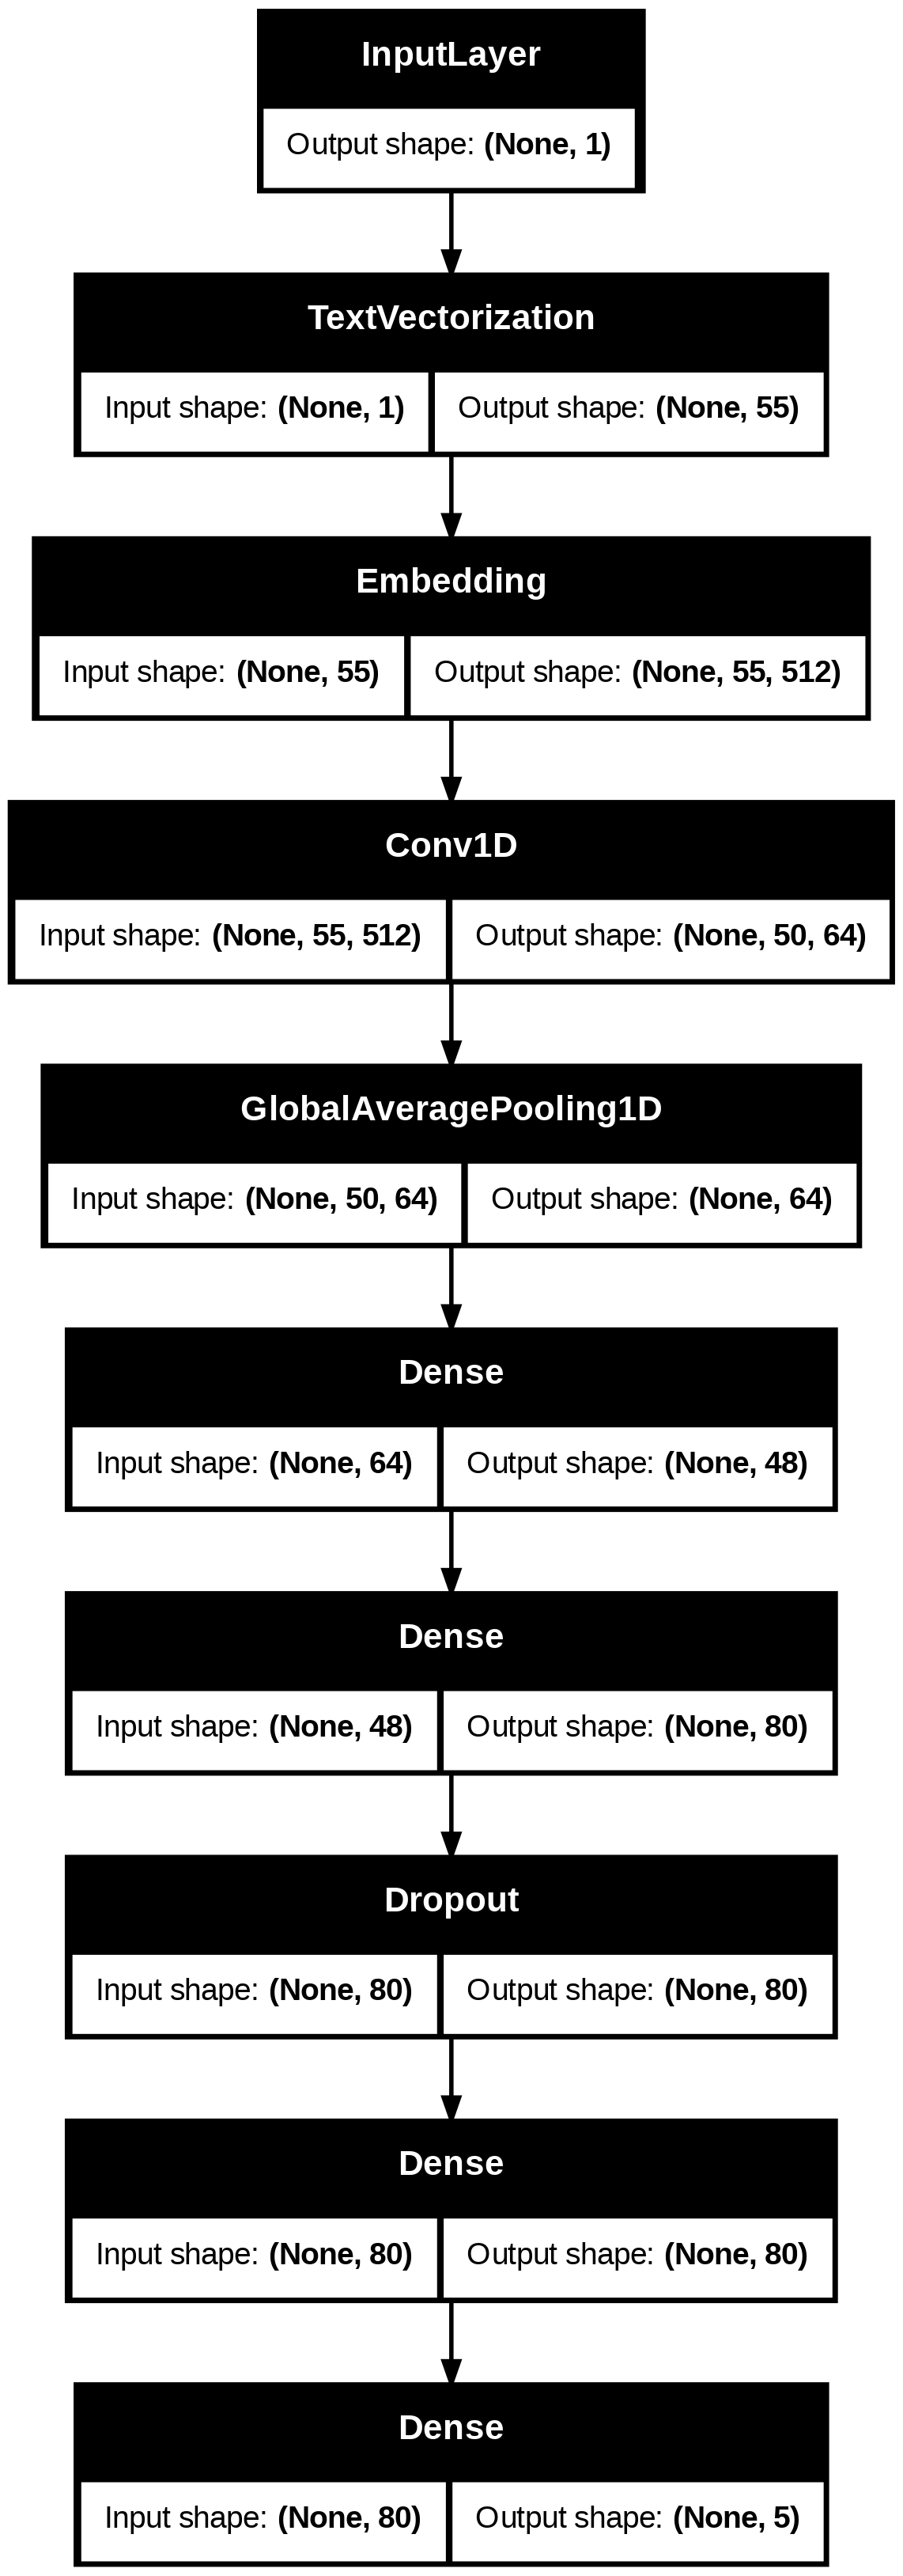

In [ ]:
plot_model(best_model,
           show_shapes=True)

## Creating Model-2 ##
Here we will use pre trained embedding layer **universal_sentence_encoder**(Trainable) instead of out custom embedding layer. except this everything will be similar to previous model

In [ ]:
pretrained_embedding = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                      trainable=True,)#Pretrained embedding layer

def model_builder2(hp):
  inputs = layers.Input(shape=(),dtype="string")
  x = pretrained_embedding(inputs)
  for i in range(hp.Int("Num_Dense_Layer", 1,20)):
    x = layers.Dense(
        units=hp.Int(f"Dense_layer_{i}_units",16,512,32),
        activation=hp.Choice(f"Dense_layer_{i}_Activation",["relu","tanh"])
    )(x)
    if hp.Choice(f"DroupOut_{i}",[1,2])==1:
      x=layers.Dropout(hp.Float(f"DroupOut_{i}_rate",0,1.0,0.1))(x)
  outputs = layers.Dense(5,activation="softmax")(x)
  model=tf.keras.Model(inputs,outputs)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2,1e-3,1e-4])),
                metrics=["accuracy"])
  return model

In [ ]:
tunner2 =kt.RandomSearch(
    hypermodel=model_builder2,
    objective="val_accuracy",
    max_trials=5,
    directory="SkimLit_tunned_models",
    project_name="SkimLit_tunned_model_2"
)

In [ ]:
tunner2.search(train_dataset,steps_per_epoch=int(0.1*(len(train_sentences)//32)),epochs=5,validation_data=val_dataset,validation_steps=int(0.1*(len(val_sentences)//32)))

Epoch 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InvalidArgumentError: Graph execution error:

Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected at node data defined at (most recent call last):
<stack traces unavailable>
Detected unsupported operations when trying to compile graph __inference_one_step_on_data_72460[] on XLA_GPU_JIT: _Arg (No registered '_Arg' OpKernel for XLA_GPU_JIT devices compatible with node {{node data}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, _output_shapes=[[32]], _user_specified_name="data", index=0){{node data}}
The op is created at: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-29-e5cea3526447>", line 3, in <cell line: 3>
File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 234, in search
File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/polymorphism/function_type.py", line 356, in placeholder_arguments
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 250, in placeholder_value
File "/usr/local/lib/python3.10/dist-packages/tensorflow/core/function/trace_type/default_types.py", line 251, in <listcomp>
	tf2xla conversion failed while converting __inference_one_step_on_data_72460[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_73075]


In [ ]:
best_model2 = tunner2.get_best_models(num_models=1)[0]
model2_checkpoint_callback=model_checkpoint(model_name="Model-2.weights.h5")

In [ ]:
best_model2.fit(train_dataset,steps_per_epoch=int(0.2*(len(train_sentences)//32)),epochs=10,validation_data=val_dataset,validation_steps=int(0.2*(len(val_sentences)//32)),callbacks=[model2_checkpoint_callback])

Epoch 1/10
1125/1125 [==============================] - 741s 660ms/step - loss: 0.4187 - accuracy: 0.8613 - val_loss: 0.5472 - val_accuracy: 0.8082
Epoch 2/10
1125/1125 [==============================] - 775s 689ms/step - loss: 0.3381 - accuracy: 0.8912 - val_loss: 0.5443 - val_accuracy: 0.8188
Epoch 3/10
1125/1125 [==============================] - 824s 733ms/step - loss: 0.3326 - accuracy: 0.8958 - val_loss: 0.5428 - val_accuracy: 0.8205
Epoch 4/10
1125/1125 [==============================] - 893s 794ms/step - loss: 0.4261 - accuracy: 0.8630 - val_loss: 0.5584 - val_accuracy: 0.8265
Epoch 5/10
1125/1125 [==============================] - 106s 94ms/step - loss: 0.5316 - accuracy: 0.8214 - val_loss: 0.5620 - val_accuracy: 0.7944
Epoch 6/10
   2/1125 [..............................] - ETA: 37:58 - loss: 0.7529 - accuracy: 0.7750

1125/1125 [==============================] - 4s 3ms/step - loss: 0.7529 - accuracy: 0.7750 - val_loss: 0.5497 - val_accuracy: 0.8103


In [ ]:
best_model2.load_weights(str(curr_dir_path)+"/Skimlit_model_checkpoints/Model-2.weights.h5")
best_model2.evaluate(test_dataset)

942/942 [==============================] - 24s 25ms/step - loss: 0.5828 - accuracy: 0.8124


[0.5828481316566467, 0.812410831451416]

In [ ]:
best_model2.save(str(curr_dir_parent)+"/SkimLit_Models/Model-2.keras")

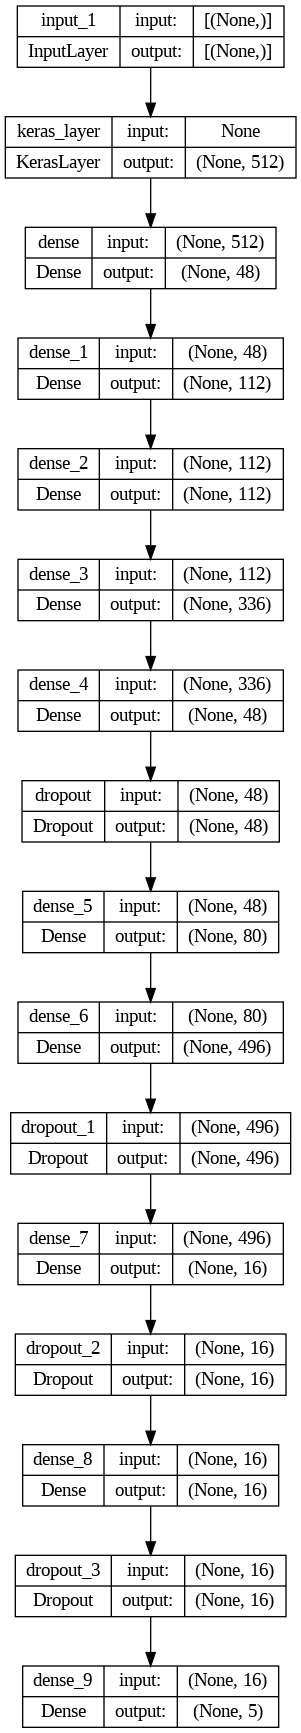

In [ ]:
plot_model(best_model2,
           show_shapes=True)

##Creating A character level tokenization for our upcoming models##

### Creating A function to split sentences into charaters ###
**split_chars()** is a function which make array of characters and join them with whitespace

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  char_arr=[i for i in text]
  return " ".join(char_arr)

### Creating data list which contain sentences with character level split ###

In [ ]:
train_char = [split_chars(sentence) for sentence in train_sentences]
val_char = [split_chars(sentence) for sentence in val_sentences]
test_char = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
[len(sentence) for sentence in train_sentences][:5]

[281, 137, 111, 65, 209]

### Distribution of sentences according to number of character ###

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <BarContainer object of 10 artists>)

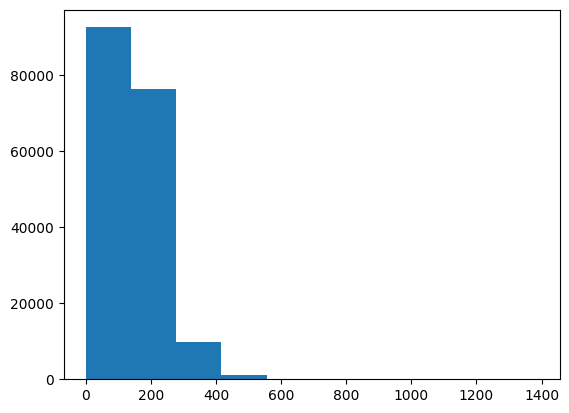

In [ ]:
plt.hist([len(sentence) for sentence in train_sentence])

In [ ]:
#Number of characters which cover 95% of sentences
avg_char=np.percentile([len(sentence) for sentence in train_sentence],95)

In [ ]:
# Get all keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Creating the character level vectorizer ###

In [ ]:
char_vect = layers.TextVectorization(
    max_tokens=len(alphabet)+2,
    output_sequence_length=int(avg_char),
    standardize="lower_and_strip_punctuation",
    name="char_vectorizer")
char_vect.adapt(train_char)

In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_char)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vect([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
s i g n i f i c a n c e   w a s   s e t   a t   p   <   @   .

Length of chars: 24

Vectorized chars:
[[ 9  4 18  6  4 17  4 11  5  6 11  2 20  5  9  9  2  3  5  3 14  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a char level embedding ##

In [ ]:
char_embedding = layers.Embedding(input_dim=len(char_vect.get_vocabulary()),
                                  output_dim=25,
                                  mask_zero=False,
                                  name="char_embed")

## Testing of character level tokenizer and embedding on samples ##

Here we will try this tokenizer and embedding and see how our character data look and how it work on it.

In [ ]:
random_train_chars = random.choice(train_char)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vect([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nEmbeded chars:\n{char_embedding(vectorized_chars)}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
w e   c o m p a r e d   t h e   e f f e c t s   o f   m o d e r a t e   b u t t e r   i n t a k e   ,   m o d e r a t e   o l i v e   o i l   i n t a k e   ,   a n d   a   h a b i t u a l   d i e t   o n   b l o o d   l i p i d s   ,   h i g h - s e n s i t i v i t y   c - r e a c t i v e   p r o t e i n   (   h s c r p   )   ,   g l u c o s e   ,   a n d   i n s u l i n   .

Length of chars: 156

Vectorized chars:
[[20  2 11  7 15 14  5  8  2 10  3 13  2  2 17 17  2 11  3  9  7 17 15  7
  10  2  8  5  3  2 22 16  3  3  2  8  4  6  3  5 23  2 15  7 10  2  8  5
   3  2  7 12  4 21  2  7  4 12  4  6  3  5 23  2  5  6 10  5 13  5 22  4
   3 16  5 12 10  4  2  3  7  6 22 12  7  7 10 12  4 14  4 10  9 13  4 18
  13  9  2  6  9  4  3  4 21  4  3 19 11  8  2  5 11  3  4 21  2 14  8  7
   3  2  4  6 13  9 11  8 14 18 12 16 11  7  9  2  5  6 10  4  6  9 16 12
   4  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a prefetched and batched dataset of char for model ##

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_char,train_labels_ohc)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_char,val_labels_ohc)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_char,test_labels_ohc)).batch(32).prefetch(tf.data.AUTOTUNE)
#train_char_dataset

## Building the 3rd Model ##
This model will work on character level tokenization followed by character level embedding. Except this model have **Conv1D**,**Dense**,**Dropout**,**GAP** layers

In [ ]:
def model_builder3(hp):
  input = layers.Input(shape=(),dtype="string")
  x=char_vect(input)
  x=char_embedding(x)
  for i in range(hp.Int("Num_Conv_1D_Layer",1,10)):
    x=layers.Conv1D(
        filters=hp.Int(f"Conv_1D_{i}_filters",16,64,16),
        kernel_size=hp.Int(f"Conv_!D_{i}_kernel",5,7),
        activation=hp.Choice(f"Conv_1D_{i}_Activation",["relu","tanh"]),
        padding="same"
    )(x)
  if hp.Choice(f"Pooling_Layer",[1,2])==1:
    x=layers.GlobalAveragePooling1D()(x)
  else:
    x=layers.GlobalMaxPooling1D()(x)
  for i in range(hp.Int("Num_Dense_Layer",1,10)):
    x=layers.Dense(
        units=hp.Int(f"Dense_layer_{i}_units",16,64,16),
        activation=hp.Choice(f"Dense_layer_{i}_Activation",["relu","tanh"])
    )(x)
    if hp.Choice(f"DroupOut_{i}",[1,2])==1:
      x=layers.Dropout(hp.Float(f"DroupOut_{i}_rate",0,1.0,0.1))(x)
  output = layers.Dense(5,activation="softmax")(x)
  model=tf.keras.Model(input,output)
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2,1e-3,1e-4])),
                metrics=["accuracy"])
  return model

In [ ]:
tunner3 = kt.RandomSearch(
    hypermodel=model_builder3,
    objective="val_accuracy",
    max_trials=5,
    directory="SkimLit_tunned_models",
    project_name="SkimLit_tunned_model_3"
)

In [ ]:
tunner3.search(train_char_dataset,steps_per_epoch=int(0.1*len(train_char_dataset)),epochs=5,validation_data=val_char_dataset,validation_steps=int(0.1*len(val_char_dataset)))

Trial 5 Complete [00h 00m 53s]
val_accuracy: 0.3321143686771393

Best val_accuracy So Far: 0.36702126264572144
Total elapsed time: 00h 04m 09s


In [ ]:
best_model3 = tunner3.get_best_models(num_models=1)[0]
model3_checkpoint_callback=model_checkpoint(model_name="Model-3.weights.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 40 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model3.fit(train_char_dataset,epochs=10,validation_data=val_char_dataset,validation_steps=int(0.1*len(val_char_dataset)),callbacks=[model3_checkpoint_callback])

Epoch 1/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step - accuracy: 0.3755 - loss: 1.3420 - val_accuracy: 0.4195 - val_loss: 1.1815
Epoch 2/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - accuracy: 0.4378 - loss: 1.1858 - val_accuracy: 0.4711 - val_loss: 1.1185
Epoch 3/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 49s 9ms/step - accuracy: 0.4740 - loss: 1.1364 - val_accuracy: 0.4990 - val_loss: 1.1028
Epoch 4/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step - accuracy: 0.5086 - loss: 1.0965 - val_accuracy: 0.5559 - val_loss: 1.0207
Epoch 5/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.5535 - loss: 1.0357 - val_accuracy: 0.5967 - val_loss: 0.9704
Epoch 6/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 79s 9ms/step - accuracy: 0.5971 - loss: 0.9632 - val_accuracy: 0.6353 - val_loss: 0.8617
Epoch 7/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - accuracy: 0.6258 - loss: 0.9112 - val_accuracy: 0.6539 - val_loss: 0.8346
Epoch 8/10
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - accuracy: 0.6437 - loss: 

In [ ]:
best_model3.load_weights(str(curr_dir_path)+"/Skimlit_model_checkpoints/Model-3.weights.h5")
best_model3.evaluate(test_char_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6702 - loss: 0.8221


[0.8215225338935852, 0.67127925157547]

In [ ]:
best_model3.save(str(curr_dir_parent)+"/SkimLit_Models/Model-3.keras")

## Creating a multi-input model ##



In [ ]:
#MultiModel NLP

#Token_Input
token_input = layers.Input(shape=(1,),dtype=tf.string,name="token_input")
token_vect = text_vect(token_input)
token_embedding=layers.Embedding(input_dim=len(text_vect.get_vocabulary()),
                                  output_dim=512,
                                  mask_zero=False)
token_embedding_layer=token_embedding(token_vect)
max_pool_layer = layers.GlobalMaxPool1D()(token_embedding_layer)
token_output = layers.Dense(128,activation="relu")(max_pool_layer)
token_model=tf.keras.Model(token_input,token_output)

#Char_Input
char_input = layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vect_layer = char_vect(char_input)
char_embedding = layers.Embedding(input_dim=len(char_vect.get_vocabulary()),
                                  output_dim=25,
                                  mask_zero=False,)
char_embedding_layer=char_embedding(char_vect_layer)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embedding_layer)
char_model=tf.keras.Model(char_input,char_bi_lstm)


#Concat token and char input
concat=layers.Concatenate(name="token_char_concat")([token_model.output,
                                                     char_model.output])
combined_dropout = layers.Dropout(0.5)(concat)
combined_dense = layers.Dense(200,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
final_output = layers.Dense(5,activation="softmax")(final_dropout)

multi_model=tf.keras.Model(inputs=[token_model.input,char_model.input],
                           outputs=final_output)

In [ ]:
multi_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorizer           │ (None, 55)             │              0 │ token_input[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 55, 512)        │     33,198,592 │ text_vectorizer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_vectorizer           │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 512)            │              0 │ embedding_8[0][0]      │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_9 (Embedding)   │ (None, 290, 25)        │            700 │ char_vectorizer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 128)            │         65,664 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 48)             │          9,600 │ embedding_9[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_concat         │ (None, 176)            │              0 │ dense_16[0][0],        │
│ (Concatenate)             │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 176)            │              0 │ token_char_concat[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 200)            │         35,400 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 200)            │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 5)              │          1,005 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,310,961 (127.07 MB)

 Trainable params: 33,310,961 (127.07 MB)

 Non-trainable params: 0 (0.00 B)

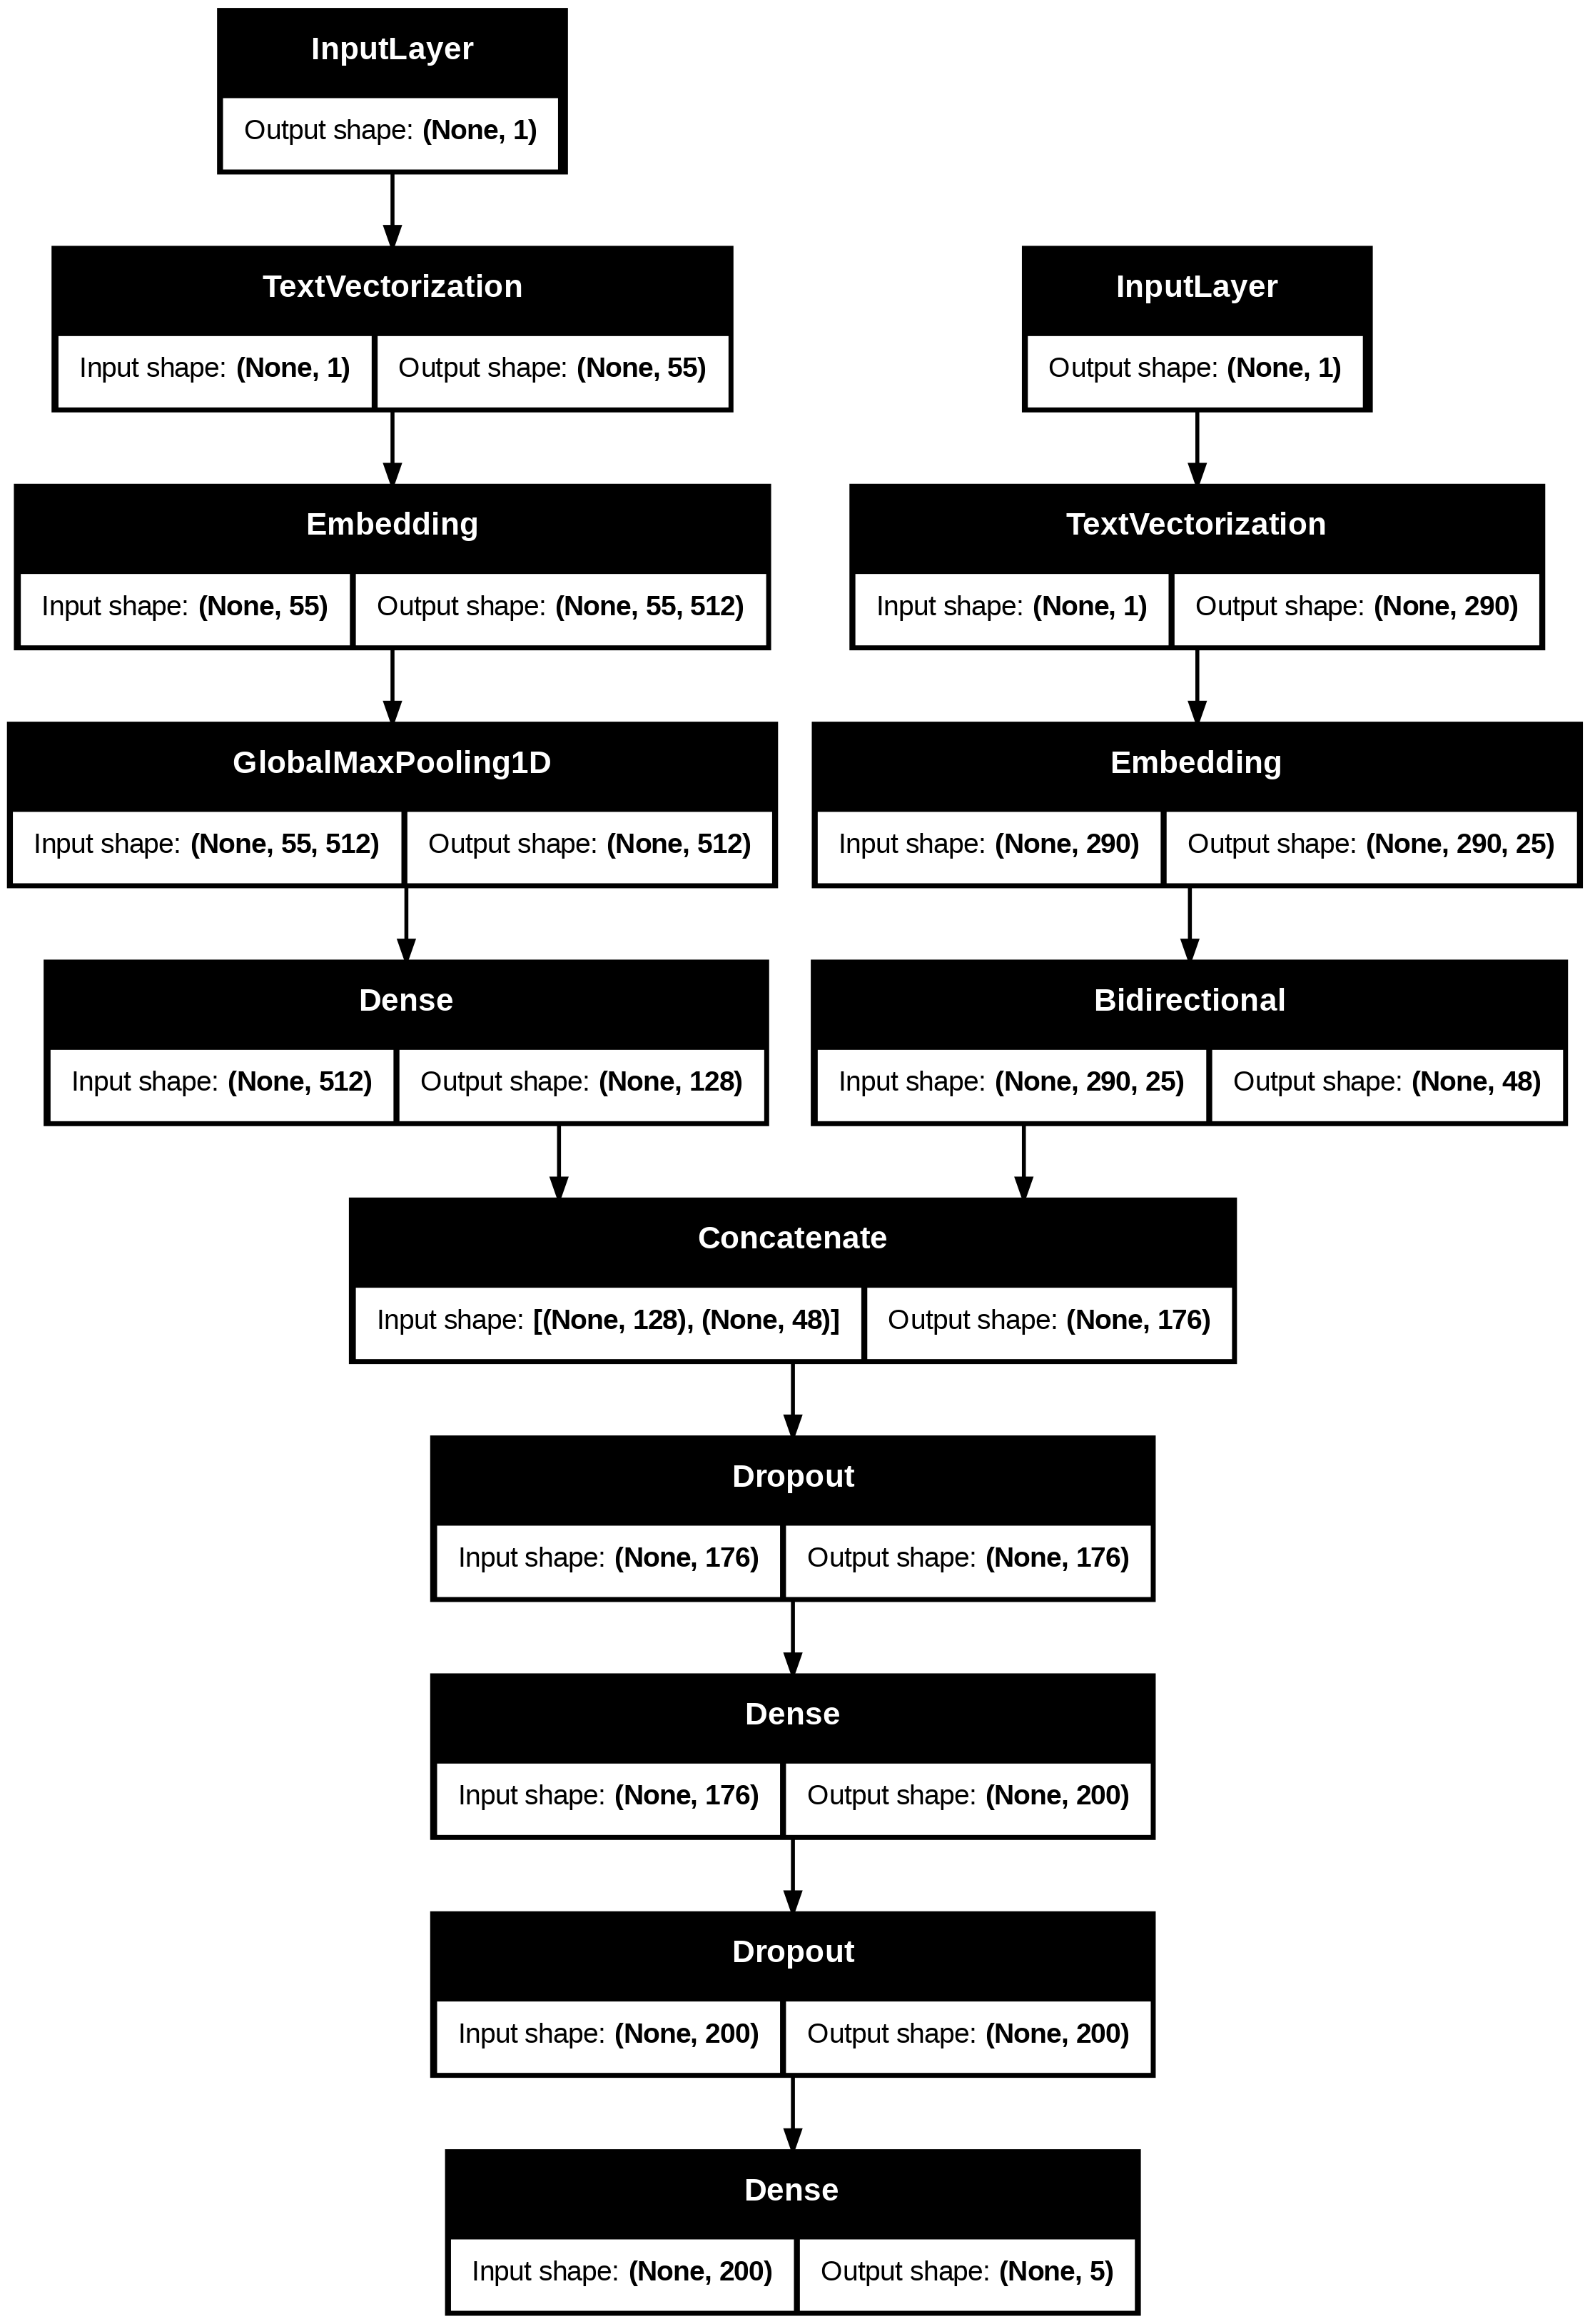

In [ ]:
plot_model(multi_model,
           show_shapes=True)

In [ ]:
multi_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(1e-3),
                metrics=["accuracy"])

In [ ]:
#Combine token and char dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_char))
train_char_token_label = tf.data.Dataset.from_tensor_slices((train_labels_ohc))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_char))
val_char_token_label = tf.data.Dataset.from_tensor_slices((val_labels_ohc))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
multi_model.fit(train_char_token_dataset,
                steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                epochs=10,
                validation_data=val_char_token_dataset,
                validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.4513 - loss: 1.2378 - val_accuracy: 0.7440 - val_loss: 0.6540
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.7278 - loss: 0.7135 - val_accuracy: 0.7753 - val_loss: 0.5923
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.7601 - loss: 0.6467 - val_accuracy: 0.7932 - val_loss: 0.5416
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.7745 - loss: 0.6271 - val_accuracy: 0.8092 - val_loss: 0.5272
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.7790 - loss: 0.6172 - val_accuracy: 0.8032 - val_loss: 0.5332
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.7860 - loss: 0.6004 - val_accuracy: 0.8025 - val_loss: 0.5382
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.7955 - loss: 0.5739 - val_accuracy: 0.8042 - val_loss: 0.5282
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.7995 - loss: 0.5674 - 

In [ ]:
multi_model.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8134 - loss: 0.4967


[0.5014652609825134, 0.8153382539749146]

In [ ]:
multi_model.save(str(curr_dir_parent)+"/SkimLit_Models/multi_model.keras")